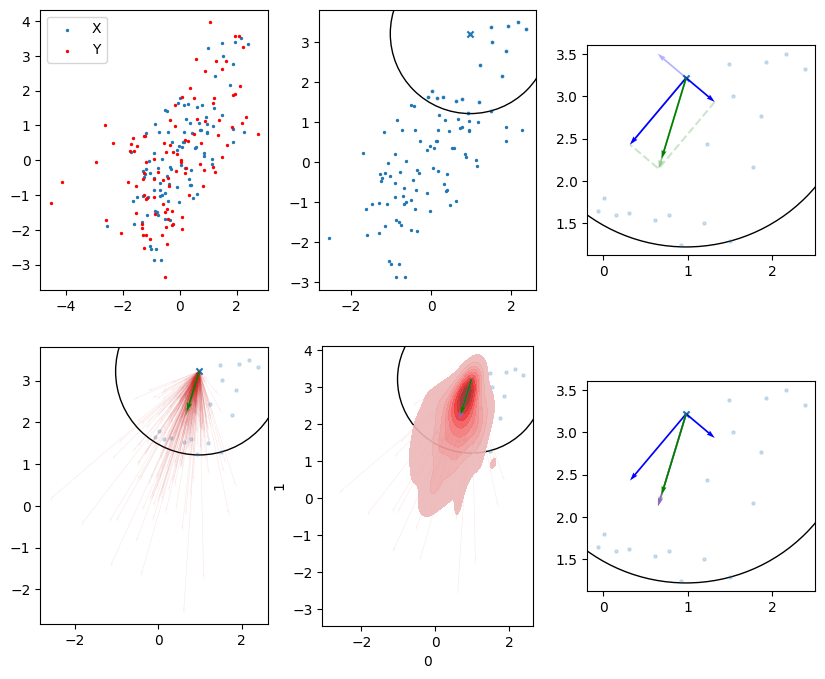

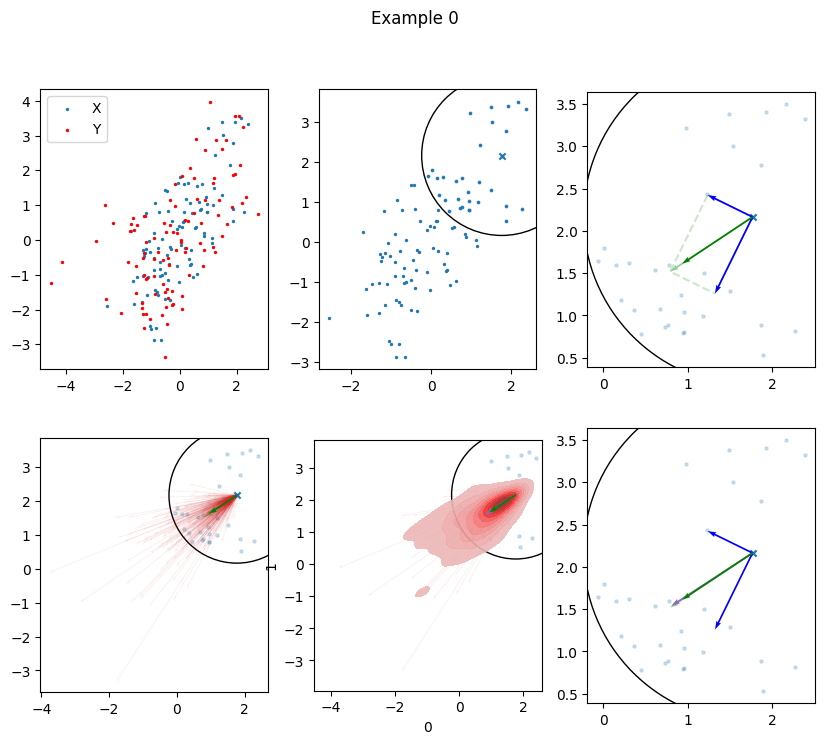

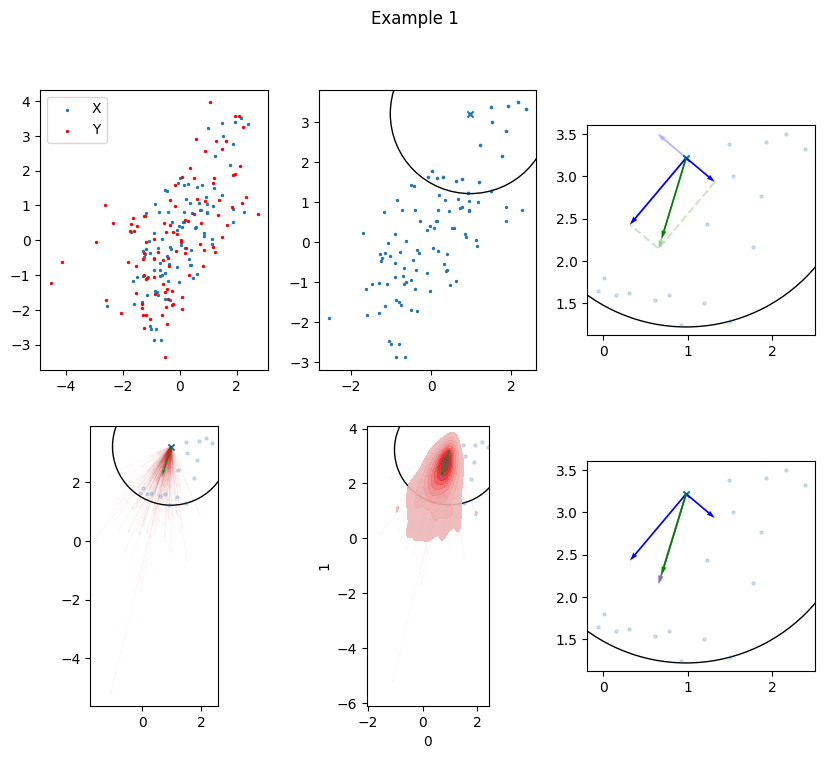

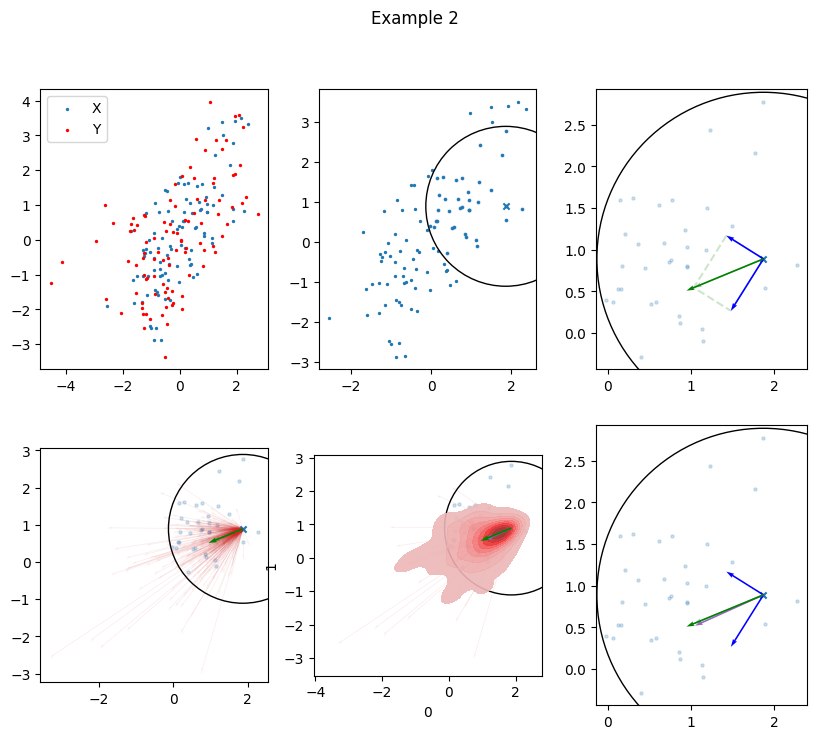

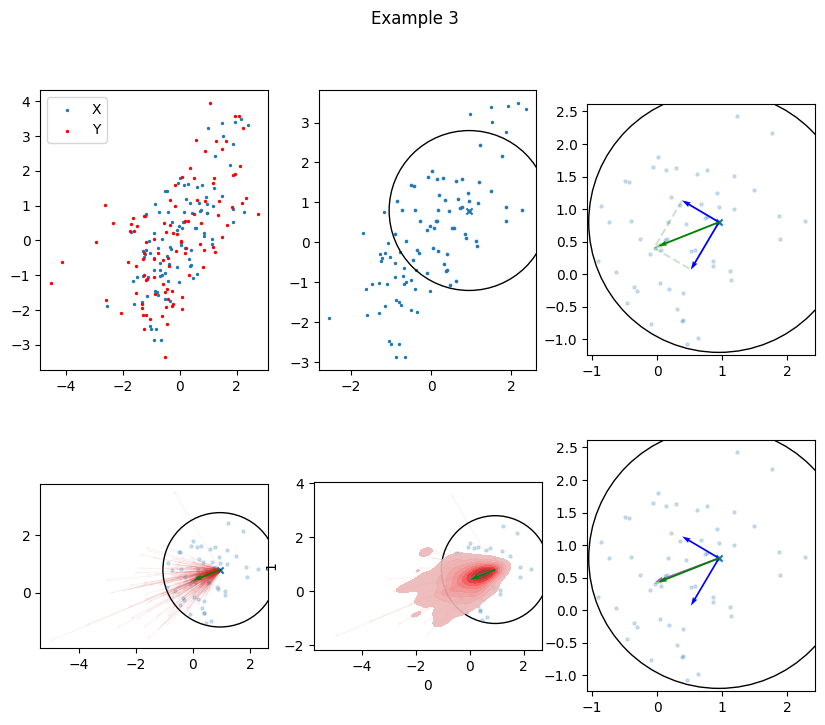

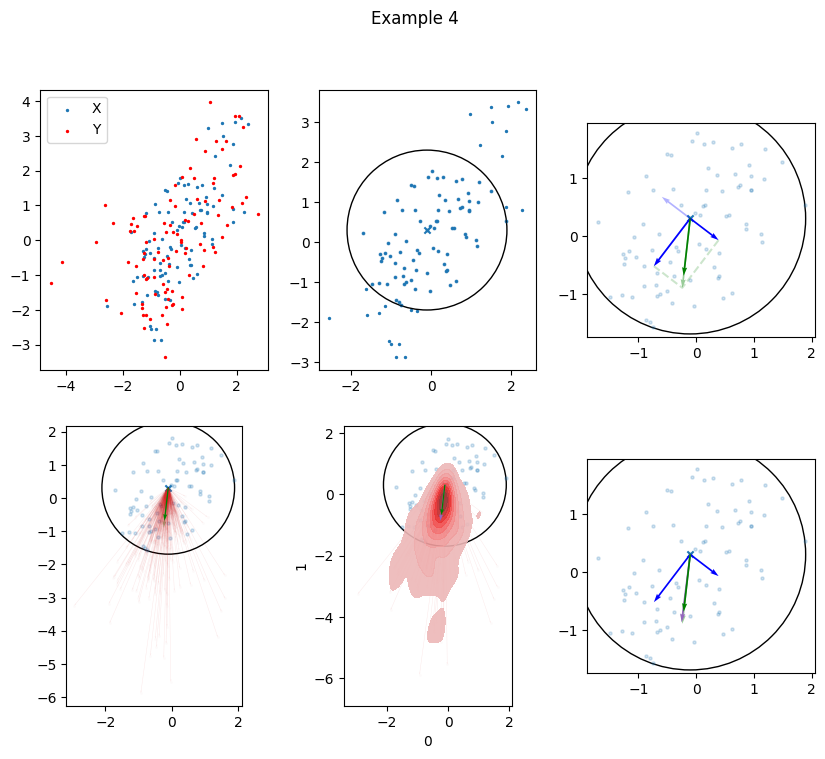

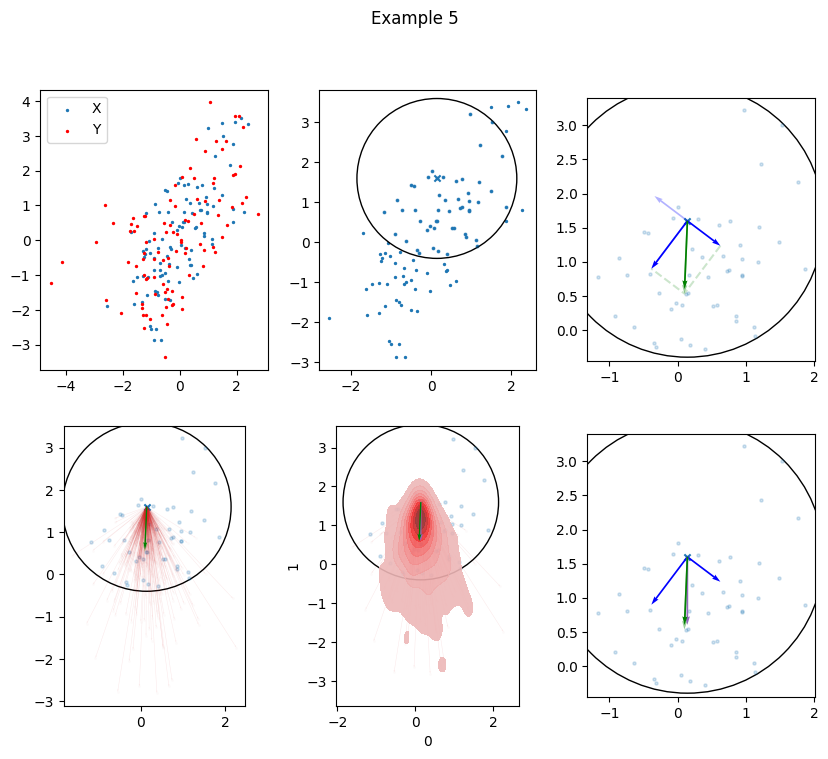

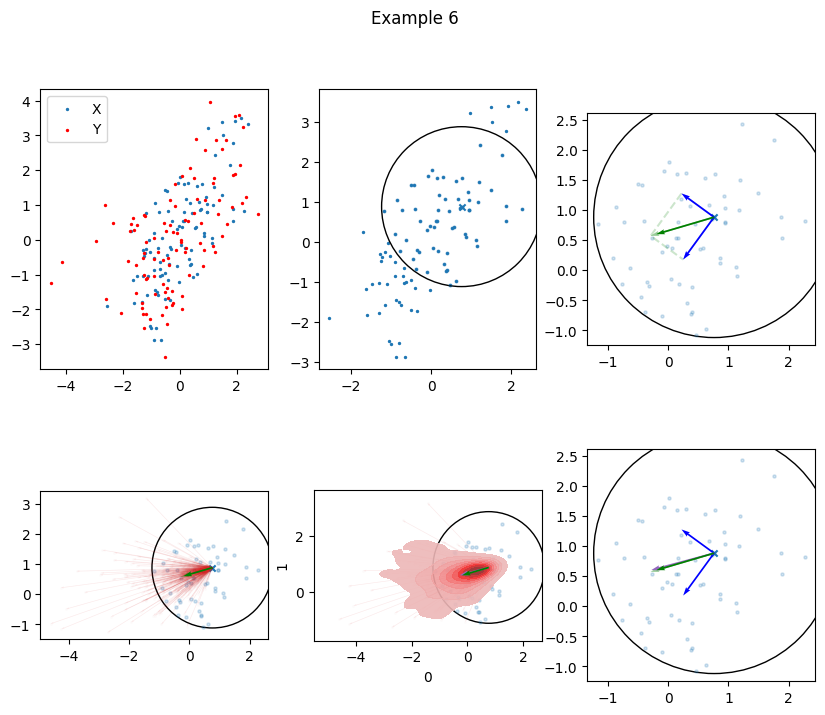

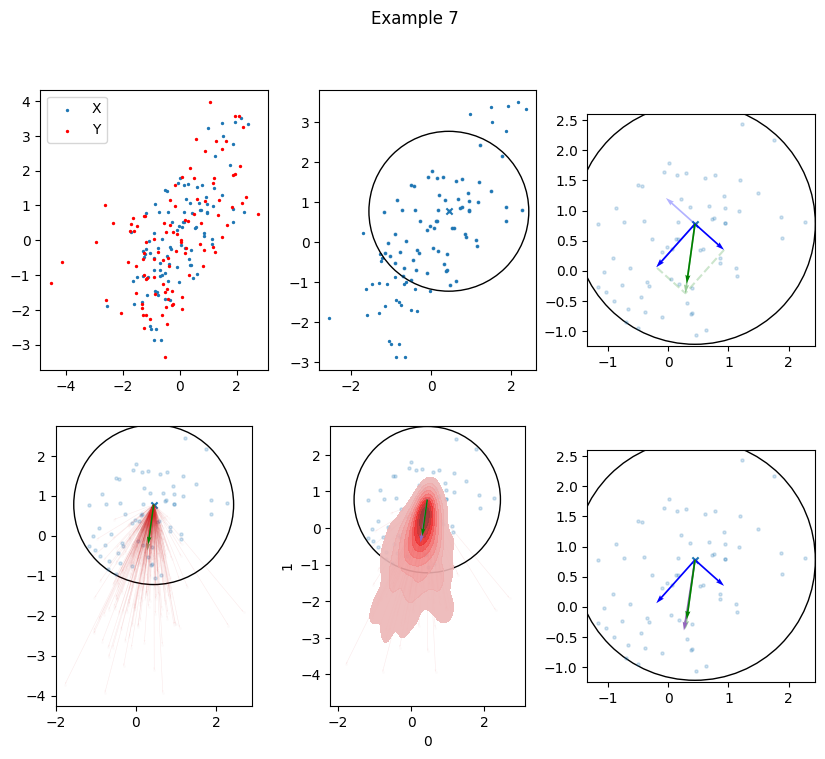

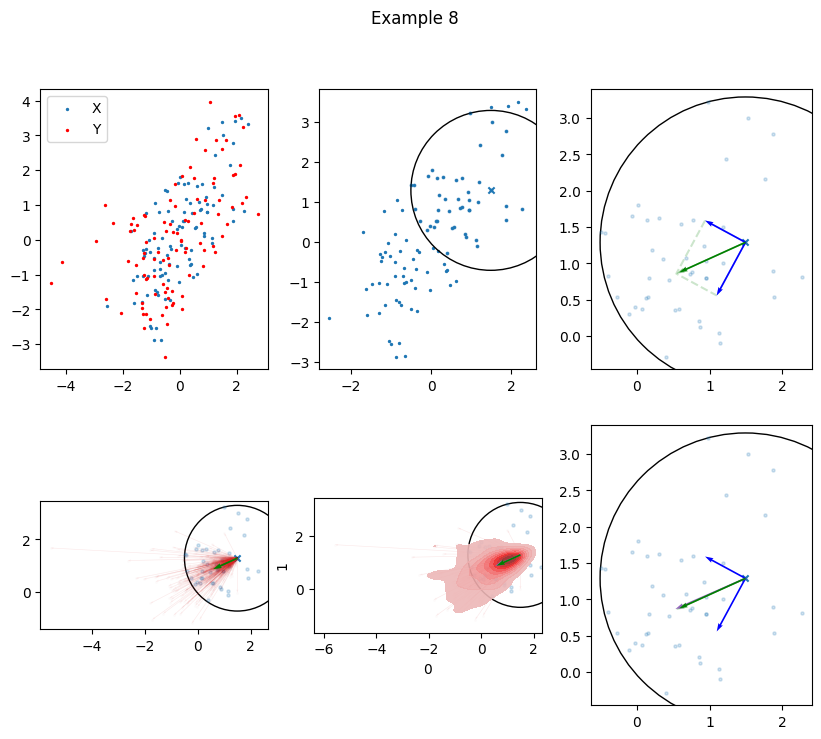

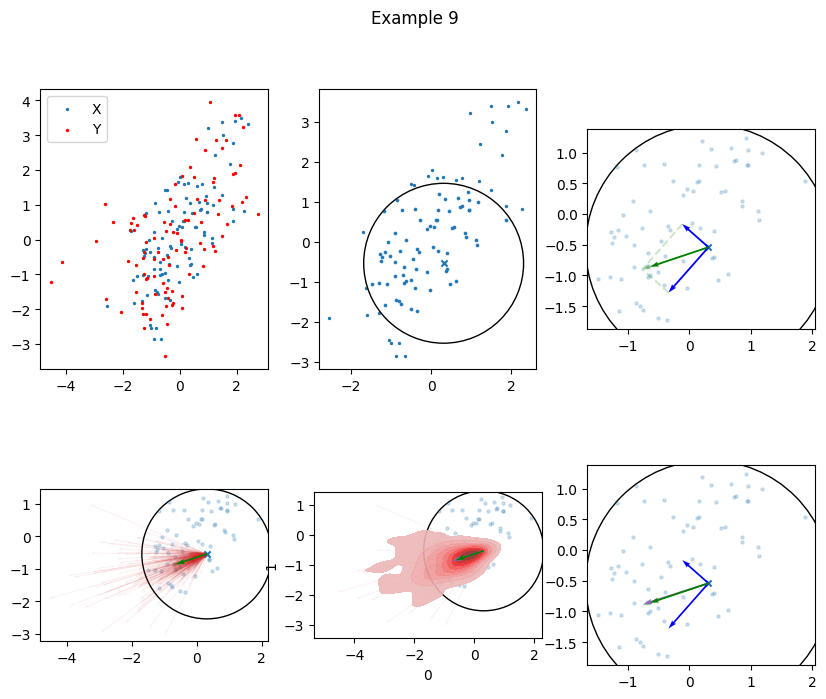

In [155]:
import numpy as np
from scipy.spatial import cKDTree
import seaborn as sns
import pandas as pd

R_noise = 1
R_explore = 2
prop_orient = 0.9
prop_sense = 0.9
concentration = 10
rand_radius = lambda size=None: np.random.gamma(2, 1, size=size) / 2

def algorithm(X: np.ndarray):
    X = np.asarray(X).astype(float)
    N, n = X.shape
    Y = X * np.nan
    # Prepare nearest neighbor search
    tree = cKDTree(X)
    for i_x in range(N):
        x = X[i_x]
        # Compute neighbors in radius R_noise
        idx = tree.query_ball_point(x, r=R_explore, p=2)
        Nx = X[idx] - x
        # Diagonalize covariance matrix
        cov = np.cov(Nx.T)
        diag, V = np.linalg.eig(cov)
        lambdas = np.sqrt(diag)
        # Choose the sense of each eigenvector
        for i in range(n):
            if prop_sense == 1 or np.random.random() < prop_sense:
                p_invert = 0.5
            else:
                # Count the number of neighbors in the direction of the eigenvector
                count = np.sum(Nx @ V[:,i] > 0)
                p_invert = 1 - count / len(Nx)
            if np.random.rand() < p_invert:
                V[:,i] *= -1
        # Sample a random direction
        u = V @ np.random.vonmises(lambdas, concentration)
        u *= R_noise * rand_radius()
        y = x + u
        Y[i_x] = y
    return Y


def algorithm_plot(X: np.ndarray, i_x=None, axes=None):
    X = np.asarray(X).astype(float)
    tree = cKDTree(X)
    N, n = X.shape
    assert n==2
    if i_x is None:
        i_x = np.random.randint(N)
    x = X[i_x]
    idx = tree.query_ball_point(x, r=R_explore, p=2)
    Nx = X[idx] - x
    # Diagonalize covariance matrix
    cov = np.cov(Nx.T)
    diag, V = np.linalg.eig(cov)
    V_before = V.copy()
    lambdas = np.sqrt(diag)
    # Choose the sense of each eigenvector
    for i in range(n):
        # Count the number of neighbors in the direction of the eigenvector
        count = np.sum(Nx @ V[:,i] > 0)
        p_invert = 1 - count / len(Nx)
        if 0.5 < p_invert:
            V[:,i] *= -1
    
    AxesType = plt.Axes # type:ignore
    def subset_plot(ax:"AxesType", show=[]):
        features = {k:True for k in show}
        ax.set_aspect('equal')
        if features.get('X'):
            ax.scatter(X[:,0], X[:,1], label='X', s=2, color='tab:blue')
        if features.get('x'):
            ax.scatter(x[None,0], x[None,1], marker='x', s=20, color='tab:blue')
        if features.get('circle'):
            circle = plt.Circle(x, R_explore, fill=False) # type: ignore
            ax.add_artist(circle)
        if features.get('Nx'):
            ax.scatter(x[0]+Nx[:,0], x[1]+Nx[:,1], label='X', s=5, marker='o', color='tab:blue', alpha=0.2)
        if features.get('V_before'):
            for i_v in range(n):
                u = V_before[:, i_v] * lambdas[i_v]
                ax.quiver(*x, *u, scale=1, scale_units='xy', color='blue', alpha=0.3)
        if features.get('V'):
            for i_v in range(n):
                u = V[:, i_v] * lambdas[i_v]
                ax.quiver(*x, *u, scale=1, scale_units='xy', color='blue', ls='--')
                #ax.plot(*np.array([x, x + u]).T, c='k', ls='--', alpha=0.2)
        if features.get('dir_V'):
            # Sample a random direction
            ax.quiver(*x, *dir_V, scale=1, scale_units='xy', color='green', alpha=0.4)
        if features.get('dir_V_dashes'):
            data = [x + V[:, 0] * lambdas[0], x + dir_V, x + V[:, 1] * lambdas[1]]
            ax.plot(*np.array(data).T, c='green', ls='--', alpha=0.2)
        if features.get('Y'):
            ax.scatter(Y[:,0], Y[:,1], s=2, c='tab:red', alpha=0.01) # For the plot limits 
            xx = np.zeros_like(Y)
            xx[:] = x[None,:]
            ax.quiver(*xx.T, *(Y-x[None,:]).T, scale=1, scale_units='xy', color='tab:red', alpha=0.1)
        if features.get('Y_contour'):
            sns.kdeplot(data=pd.DataFrame(Y), x=0, y=1, ax=ax, color='tab:red',fill=True, alpha=0.9)
        if features.get('y'):
            ax.quiver(*x, *(y-x),  scale=1, scale_units='xy', color='tab:red', alpha=1)
        if features.get('y_mean'):
            ax.quiver(*x, *(y_mean-x),  scale=1, scale_units='xy', color='tab:purple', alpha=1)
        if features.get('dir_R'):
            # Sample a random direction
            ax.quiver(*x, *dir_R, scale=1, scale_units='xy', color='green', alpha=1)
        return
    dir_V = V @ lambdas
    dir_R = dir_V / np.linalg.norm(dir_V) * R_noise
    
    y = np.random.vonmises(lambdas, concentration) * R_noise * rand_radius()
    y = V @ y + x

    # Do the sampling many times to show a contour plot
    N_samples = 500
    Y = np.random.vonmises(lambdas, concentration, size=(N_samples, 2))
    Y *= R_noise * rand_radius(N_samples)[:,None]
    Y =  (V @ Y.T).T
    Y += x[None, :]
    y_mean = np.mean(Y, axis=0)

    if axes is None:
        fig, axes = plt.subplots(2, 3, figsize=(5, 5))
        axes = axes.flatten()
    subset_plot(axes[0], show='X x circle Nx'.split())
    subset_plot(axes[1], show='x circle Nx V_before V dir_V dir_V_dashes dir_R'.split())
    subset_plot(axes[2], show='x circle Nx dir_V dir_R Y'.split())
    subset_plot(axes[3], show='x circle Nx dir_V dir_R Y Y_contour y_mean'.split())
    subset_plot(axes[4], show='x circle Nx V dir_V dir_R y_mean'.split())
    return

# Generate test data
import matplotlib.pyplot as plt

np.random.seed(0)
X = np.random.normal(0, 1, (100,2))
X[:,1] += X[:,0]
Y = algorithm(X)

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = axes.flatten()
axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
axes[0].legend()
algorithm_plot(X, 1, axes[1:])
plt.show()

for i in range(10):
    fig, axes = plt.subplots(2, 3, figsize=(10, 8))
    axes = axes.flatten()
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].legend()
    algorithm_plot(X, i, axes[1:])
    plt.suptitle(f"Example {i}")
    plt.show()



In [153]:
# sns.histplot(rand_radius(2000), bins="auto")
# plt.show()
